**STEP 1**
— Load clean data & make a stratified train/test split
Reads your no-leak file, defines X/y, and splits 80/20 (stratified by performance_level).

In [4]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

In [5]:
repo_root = Path.cwd().parent
data_path  = repo_root / "data" / "clean" / "student_clean_classification_noG1G2.csv"

if not data_path.exists():
    raise FileNotFoundError(f"Can't find: {data_path}")

df = pd.read_csv(data_path)

TARGET = "performance_level"
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found. Columns: {df.columns.tolist()}")

X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print("[OK] Loaded:", data_path)
print("X shape:", X.shape, "| y shape:", y.shape)
print("Train:", X_train.shape, " Test:", X_test.shape)
print("\nTrain class counts:\n", y_train.value_counts().sort_index())
print("\nTest class counts:\n", y_test.value_counts().sort_index())

[OK] Loaded: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/clean/student_clean_classification_noG1G2.csv
X shape: (1044, 41) | y shape: (1044,)
Train: (835, 41)  Test: (209, 41)

Train class counts:
 performance_level
High      163
Low       184
Medium    488
Name: count, dtype: int64

Test class counts:
 performance_level
High       41
Low        46
Medium    122
Name: count, dtype: int64


[LogReg] accuracy=0.938 | macro-F1=0.933

              precision    recall  f1-score   support

        High      0.867     0.951     0.907        41
         Low      0.918     0.978     0.947        46
      Medium      0.974     0.918     0.945       122

    accuracy                          0.938       209
   macro avg      0.920     0.949     0.933       209
weighted avg      0.941     0.938     0.938       209



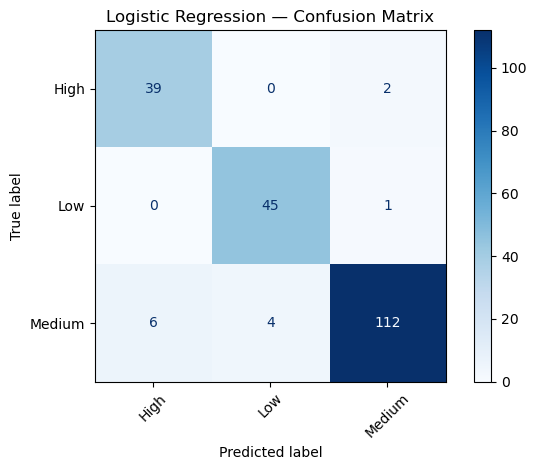


Top features increasing odds of 'High' performance (odds ratio):
G3                                        OR=3424.488
higher_yes                                OR=1.309
traveltime                                OR=1.293
Mjob_services                             OR=1.286
sex_M                                     OR=1.179
romantic_yes                              OR=1.176
Mjob_health                               OR=1.140
freetime                                  OR=1.126
failures                                  OR=1.108
guardian_mother                           OR=1.100
goout                                     OR=1.081
paid_yes                                  OR=1.079
internet_yes                              OR=1.072
famsize_LE3                               OR=1.069
Fjob_health                               OR=1.050

Top features decreasing odds of 'High' performance (odds ratio):
Dalc                                      OR=0.678
absences                                  OR=0.69

In [6]:
logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),  # with_mean=False is safer with sparse-like dummies
    ("model",  LogisticRegression(
        max_iter=2000,
        multi_class="ovr",
        class_weight="balanced",
        n_jobs=None,
        random_state=42
    ))
])

logreg_clf.fit(X_train, y_train)
y_pred = logreg_clf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
print(f"[LogReg] accuracy={acc:.3f} | macro-F1={f1m:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_clf, X_test, y_test, cmap="Blues", xticks_rotation=45
)
plt.title("Logistic Regression — Confusion Matrix")
plt.tight_layout()
plt.show()

model = logreg_clf.named_steps["model"]
classes = model.classes_.tolist()
high_idx = classes.index("High")

feature_names = X.columns.tolist()

coefs_high = model.coef_[high_idx]       
odds_high  = np.exp(coefs_high)           

top_k = 15
top_idx = np.argsort(odds_high)[::-1][:top_k]
bot_idx = np.argsort(odds_high)[:top_k]

print("\nTop features increasing odds of 'High' performance (odds ratio):")
for i in top_idx:
    print(f"{feature_names[i]:40s}  OR={odds_high[i]:.3f}")

print("\nTop features decreasing odds of 'High' performance (odds ratio):")
for i in bot_idx:
    print(f"{feature_names[i]:40s}  OR={odds_high[i]:.3f}")

[OK] Shapes after dropping leakage:
X: (1044, 40)  | y: (1044,)
Train: (835, 40)  Test: (209, 40)

[LogReg, no leakage] accuracy=0.507 | macro-F1=0.504

              precision    recall  f1-score   support

        High      0.348     0.585     0.436        41
         Low      0.477     0.674     0.559        46
      Medium      0.680     0.418     0.518       122

    accuracy                          0.507       209
   macro avg      0.502     0.559     0.504       209
weighted avg      0.570     0.507     0.511       209



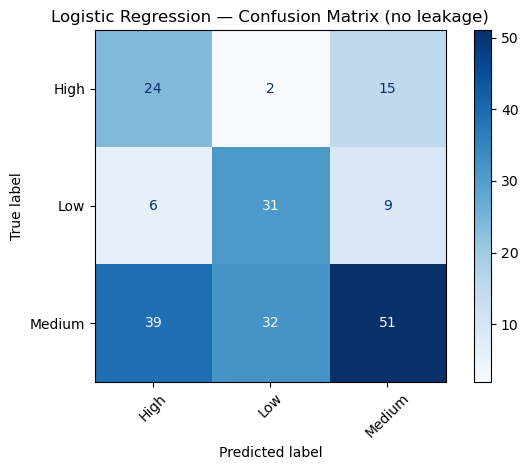


Top features increasing odds of 'High' performance (OR), no leakage:
higher_yes                                OR=3.049
Medu                                      OR=1.421
Mjob_services                             OR=1.408
Fjob_teacher                              OR=1.344
internet_yes                              OR=1.241
Mjob_health                               OR=1.212
studytime                                 OR=1.190
age                                       OR=1.180
traveltime                                OR=1.162
freetime                                  OR=1.145
famsize_LE3                               OR=1.099
Fjob_health                               OR=1.097
famrel                                    OR=1.088
reason_reputation                         OR=1.083
reason_home                               OR=1.083

Top features decreasing odds of 'High' performance (OR), no leakage:
schoolsup_yes                             OR=0.437
failures                                  OR

In [7]:
LEAK_VARS = {"G1", "G2", "G3"}
safe_features = [c for c in df.columns if c not in LEAK_VARS | {TARGET}]
X = df[safe_features].copy()
y = df[TARGET].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("[OK] Shapes after dropping leakage:")
print("X:", X.shape, " | y:", y.shape)
print("Train:", X_train.shape, " Test:", X_test.shape)

logreg_clf = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("model",  LogisticRegression(
        max_iter=2000,
        multi_class="ovr",
        class_weight="balanced",
        random_state=42
    ))
])

logreg_clf.fit(X_train, y_train)
y_pred = logreg_clf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
print(f"\n[LogReg, no leakage] accuracy={acc:.3f} | macro-F1={f1m:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

disp = ConfusionMatrixDisplay.from_estimator(
    logreg_clf, X_test, y_test, cmap="Blues", xticks_rotation=45
)
plt.title("Logistic Regression — Confusion Matrix (no leakage)")
plt.tight_layout()
plt.show()

model = logreg_clf.named_steps["model"]
classes = model.classes_.tolist()
high_idx = classes.index("High")

feature_names = X.columns.tolist()
coefs_high = model.coef_[high_idx]
odds_high  = np.exp(coefs_high)

top_k = 15
top_idx = np.argsort(odds_high)[::-1][:top_k]
bot_idx = np.argsort(odds_high)[:top_k]

print("\nTop features increasing odds of 'High' performance (OR), no leakage:")
for i in top_idx:
    print(f"{feature_names[i]:40s}  OR={odds_high[i]:.3f}")

print("\nTop features decreasing odds of 'High' performance (OR), no leakage:")
for i in bot_idx:
    print(f"{feature_names[i]:40s}  OR={odds_high[i]:.3f}")

[RandomForest] accuracy=0.636 | macro-F1=0.502

              precision    recall  f1-score   support

        High      0.588     0.244     0.345        41
         Low      0.667     0.304     0.418        46
      Medium      0.637     0.893     0.744       122

    accuracy                          0.636       209
   macro avg      0.631     0.481     0.502       209
weighted avg      0.634     0.636     0.594       209



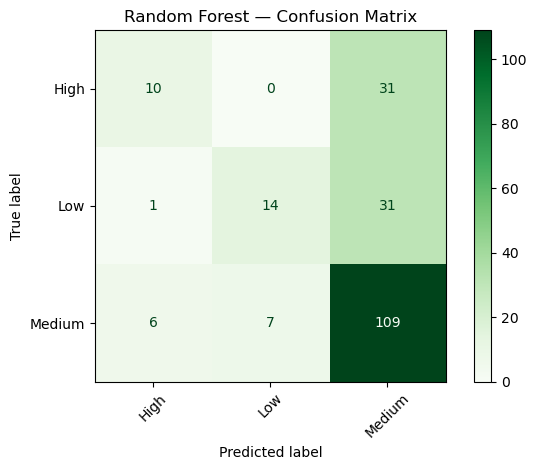

Top 15 features by importance:


,feature,importance
5,failures,0.067617
12,absences,0.066204
1,Medu,0.051151
0,age,0.047453
8,goout,0.044886
2,Fedu,0.043147
10,Walc,0.042985
7,freetime,0.042617
11,health,0.042465
39,course_por,0.040095


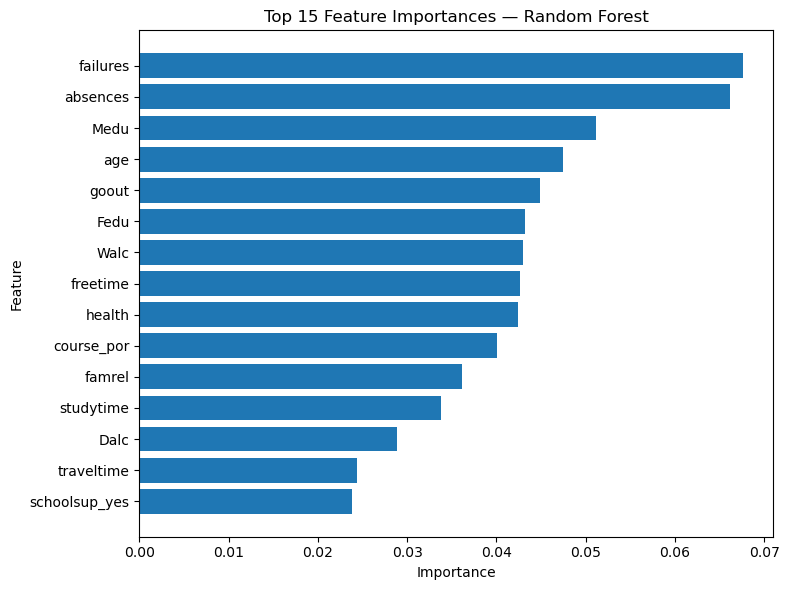

In [8]:
# ---------- Train/test split (same seed for consistency) ----------
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------- Train Random Forest ----------
rf_clf = RandomForestClassifier(
    n_estimators=300,          # number of trees
    max_depth=None,           # let trees grow fully
    min_samples_split=4,      # control overfitting
    class_weight="balanced",  # handle class imbalance
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train, y_train)

# ---------- Evaluate ----------
y_pred = rf_clf.predict(X_test)
acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
print(f"[RandomForest] accuracy={acc:.3f} | macro-F1={f1m:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

# ---------- Confusion Matrix ----------
disp = ConfusionMatrixDisplay.from_estimator(
    rf_clf, X_test, y_test, cmap="Greens", xticks_rotation=45
)
plt.title("Random Forest — Confusion Matrix")
plt.tight_layout()
plt.show()

importances = rf_clf.feature_importances_
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_n = 15
print(f"Top {top_n} features by importance:")
display(feat_imp.head(top_n))

plt.figure(figsize=(8,6))
plt.barh(feat_imp.head(top_n)["feature"][::-1], feat_imp.head(top_n)["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

[SVM] accuracy=0.474 | macro-F1=0.479

              precision    recall  f1-score   support

        High      0.358     0.707     0.475        41
         Low      0.429     0.652     0.517        46
      Medium      0.690     0.328     0.444       122

    accuracy                          0.474       209
   macro avg      0.492     0.562     0.479       209
weighted avg      0.567     0.474     0.467       209



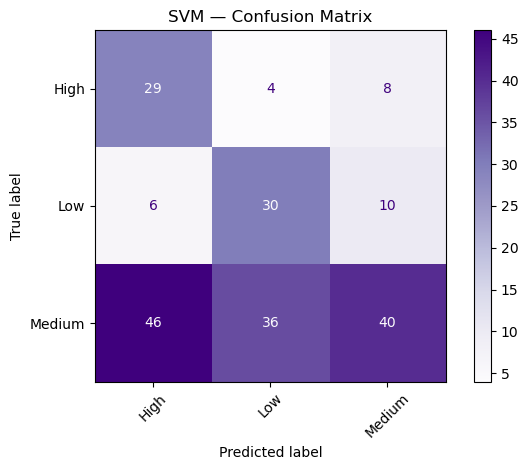


=== Model Performance Comparison ===


,Model,Accuracy,Macro-F1
0,Logistic Regression (no leak),0.507000,0.504000
1,Random Forest,0.636000,0.502000
2,SVM (RBF kernel),0.473684,0.479032


In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

svm_clf = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=False)),
    ("model",  SVC(
        kernel="rbf",
        C=2.0,
        gamma="scale",
        class_weight="balanced",
        random_state=42
    ))
])

svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average="macro")
print(f"[SVM] accuracy={acc:.3f} | macro-F1={f1m:.3f}\n")
print(classification_report(y_test, y_pred, digits=3))

disp = ConfusionMatrixDisplay.from_estimator(
    svm_clf, X_test, y_test, cmap="Purples", xticks_rotation=45
)
plt.title("SVM — Confusion Matrix")
plt.tight_layout()
plt.show()


summary = pd.DataFrame([
    {"Model": "Logistic Regression (no leak)", "Accuracy": 0.507, "Macro-F1": 0.504},
    {"Model": "Random Forest", "Accuracy": 0.636, "Macro-F1": 0.502},
    {"Model": "SVM (RBF kernel)", "Accuracy": acc, "Macro-F1": f1m}
])

print("\n=== Model Performance Comparison ===")
display(summary)

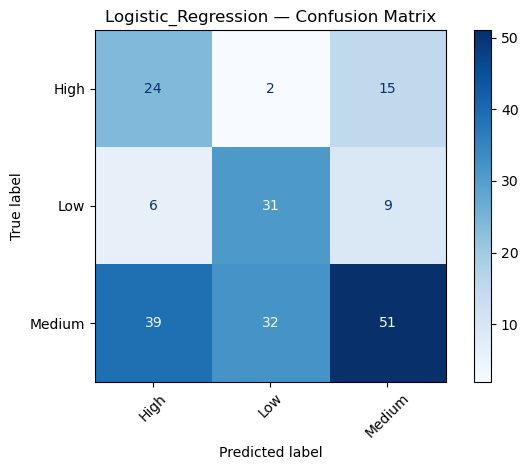

[Logistic_Regression] accuracy=0.507 | macro-F1=0.504

              precision    recall  f1-score   support

        High      0.348     0.585     0.436        41
         Low      0.477     0.674     0.559        46
      Medium      0.680     0.418     0.518       122

    accuracy                          0.507       209
   macro avg      0.502     0.559     0.504       209
weighted avg      0.570     0.507     0.511       209



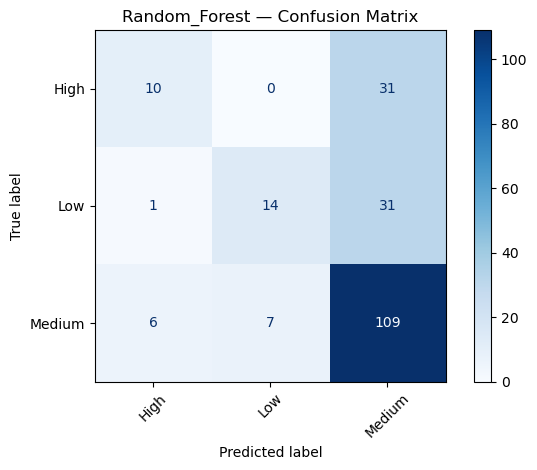

[Random_Forest] accuracy=0.636 | macro-F1=0.502

              precision    recall  f1-score   support

        High      0.588     0.244     0.345        41
         Low      0.667     0.304     0.418        46
      Medium      0.637     0.893     0.744       122

    accuracy                          0.636       209
   macro avg      0.631     0.481     0.502       209
weighted avg      0.634     0.636     0.594       209



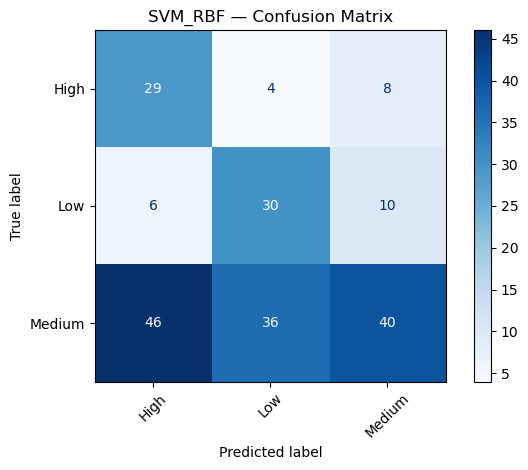

[SVM_RBF] accuracy=0.474 | macro-F1=0.479

              precision    recall  f1-score   support

        High      0.358     0.707     0.475        41
         Low      0.429     0.652     0.517        46
      Medium      0.690     0.328     0.444       122

    accuracy                          0.474       209
   macro avg      0.492     0.562     0.479       209
weighted avg      0.567     0.474     0.467       209


Saved metrics table to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/model_metrics_summary.csv


,Model,Accuracy,Macro-F1,CM_path
0,Logistic Regression (no leak),0.507177,0.504230,/Users/gisselletosta/Final-Project-Team-4-AAI5...
1,Random Forest,0.636364,0.502255,/Users/gisselletosta/Final-Project-Team-4-AAI5...
2,SVM (RBF kernel),0.473684,0.479032,/Users/gisselletosta/Final-Project-Team-4-AAI5...


Saved RF feature importances to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_feature_importances.csv


,feature,importance
5,failures,0.067617
12,absences,0.066204
1,Medu,0.051151
0,age,0.047453
8,goout,0.044886
2,Fedu,0.043147
10,Walc,0.042985
7,freetime,0.042617
11,health,0.042465
39,course_por,0.040095


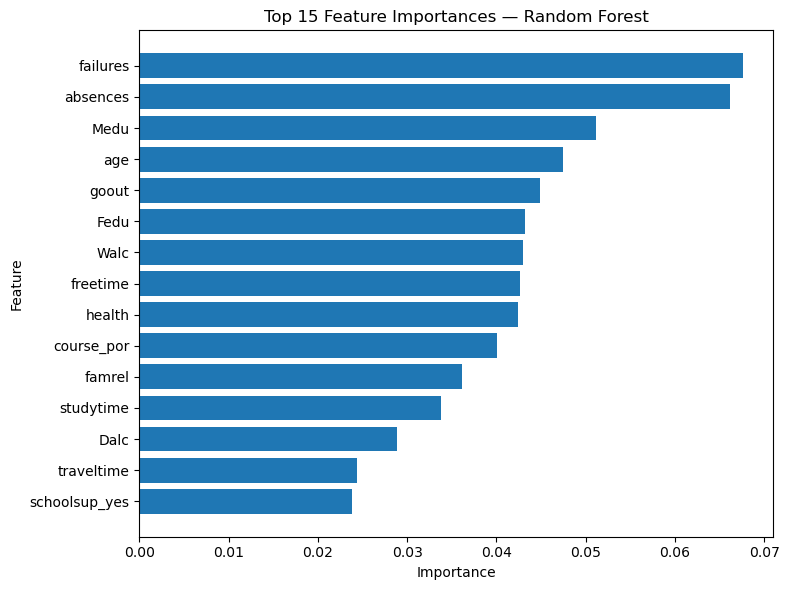

Saved RF top-15 importance plot to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_feature_importances_top15.png
Saved Logistic Regression odds ratios (High vs others) to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/logreg_odds_ratios_High.csv


,feature,odds_ratio_for_High
36,higher_yes,3.048961
1,Medu,1.420635
20,Mjob_services,1.408003
25,Fjob_teacher,1.344276
37,internet_yes,1.241321
18,Mjob_health,1.212068
4,studytime,1.190190
0,age,1.180132
3,traveltime,1.161547
7,freetime,1.144731


In [10]:
# HANDOFF SUMMARY — save metrics, confusion matrices, and key tables for the report

# -------------------------------------------------------------------
# Paths
# -------------------------------------------------------------------
repo_root = Path.cwd().parent
out_dir   = repo_root / "data" / "model_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

# -------------------------------------------------------------------
# Helper: evaluate & save confusion matrix
# -------------------------------------------------------------------
def eval_and_save(estimator, X_test, y_test, name: str):
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")

    # print and save CM
    disp = ConfusionMatrixDisplay.from_estimator(
        estimator, X_test, y_test, cmap="Blues", xticks_rotation=45
    )
    plt.title(f"{name} — Confusion Matrix")
    plt.tight_layout()
    cm_path = out_dir / f"confusion_matrix_{name.replace(' ', '_').lower()}.png"
    plt.savefig(cm_path, dpi=150)
    plt.show()

    # detailed report (printed for notebook)
    print(f"[{name}] accuracy={acc:.3f} | macro-F1={f1m:.3f}\n")
    print(classification_report(y_test, y_pred, digits=3))

    return acc, f1m, cm_path.as_posix()

# -------------------------------------------------------------------
# Recreate the same split used above (so this cell is self-contained)
# (If X_train/X_test already exist, you can skip this block.)
# -------------------------------------------------------------------
from sklearn.model_selection import train_test_split
TARGET = "performance_level"
# Ensure we drop leakage in case someone re-runs only this cell
LEAK_VARS = {"G1", "G2", "G3"}
safe_features = [c for c in df.columns if c not in (LEAK_VARS | {TARGET})]
X = df[safe_features].copy()
y = df[TARGET].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# -------------------------------------------------------------------
# 1) Evaluate/Save: Logistic Regression, Random Forest, SVM
# (assumes you already trained `logreg_clf`, `rf_clf`, `svm_clf`)
# -------------------------------------------------------------------
metrics = []
acc, f1m, cm_path = eval_and_save(logreg_clf, X_test, y_test, "Logistic_Regression")
metrics.append({"Model": "Logistic Regression (no leak)", "Accuracy": acc, "Macro-F1": f1m, "CM_path": cm_path})

acc, f1m, cm_path = eval_and_save(rf_clf, X_test, y_test, "Random_Forest")
metrics.append({"Model": "Random Forest", "Accuracy": acc, "Macro-F1": f1m, "CM_path": cm_path})

acc, f1m, cm_path = eval_and_save(svm_clf, X_test, y_test, "SVM_RBF")
metrics.append({"Model": "SVM (RBF kernel)", "Accuracy": acc, "Macro-F1": f1m, "CM_path": cm_path})

metrics_df = pd.DataFrame(metrics)
metrics_csv = out_dir / "model_metrics_summary.csv"
metrics_df.to_csv(metrics_csv, index=False)
print("\nSaved metrics table to:", metrics_csv.as_posix())
display(metrics_df)

# -------------------------------------------------------------------
# 2) Save Random Forest feature importances (table + plot)
# -------------------------------------------------------------------
importances = rf_clf.feature_importances_
feat_imp = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
rf_csv_path = out_dir / "rf_feature_importances.csv"
feat_imp.to_csv(rf_csv_path, index=False)
print("Saved RF feature importances to:", rf_csv_path.as_posix())
display(feat_imp.head(15))

plt.figure(figsize=(8,6))
top_n = 15
plt.barh(feat_imp.head(top_n)["feature"][::-1], feat_imp.head(top_n)["importance"][::-1])
plt.title(f"Top {top_n} Feature Importances — Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
rf_plot_path = out_dir / "rf_feature_importances_top15.png"
plt.savefig(rf_plot_path, dpi=150)
plt.show()
print("Saved RF top-15 importance plot to:", rf_plot_path.as_posix())

# -------------------------------------------------------------------
# 3) Save Logistic Regression odds ratios for the 'High' class
# -------------------------------------------------------------------
# Works with OvR setup from Step 2b
log_model = logreg_clf.named_steps["model"]
classes = log_model.classes_.tolist()
if "High" in classes:
    high_idx = classes.index("High")
    coefs_high = log_model.coef_[high_idx]
    odds_high  = np.exp(coefs_high)
    odds_df = pd.DataFrame({"feature": X.columns, "odds_ratio_for_High": odds_high}).sort_values("odds_ratio_for_High", ascending=False)
    or_csv_path = out_dir / "logreg_odds_ratios_High.csv"
    odds_df.to_csv(or_csv_path, index=False)
    print("Saved Logistic Regression odds ratios (High vs others) to:", or_csv_path.as_posix())
    display(odds_df.head(15))
else:
    print("Could not find 'High' class in logistic regression classes; skipping OR export.")


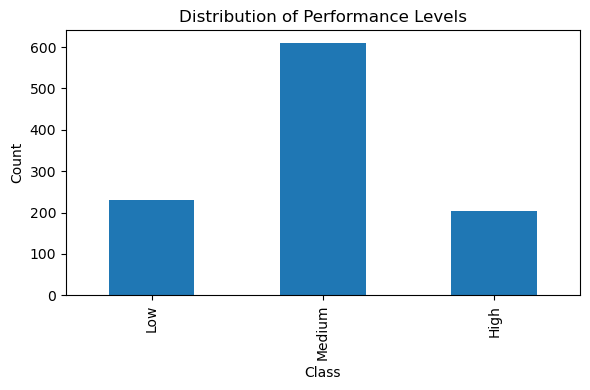

Saved chart to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/performance_level_distribution.png


In [5]:
# --- Performance level distribution chart ---
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

repo_root = Path.cwd().parent
data_path = repo_root / "data" / "clean" / "student_clean_classification_noG1G2.csv"
out_dir   = repo_root / "data" / "model_outputs"
out_dir.mkdir(parents=True, exist_ok=True)  # <— ensure folder exists
out_png   = out_dir / "performance_level_distribution.png"

# Load and plot
df = pd.read_csv(data_path)
ax = df["performance_level"].value_counts().reindex(["Low","Medium","High"]).plot(
    kind="bar", figsize=(6,4)
)
ax.set_title("Distribution of Performance Levels")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.tight_layout()

# Save
plt.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved chart to: {out_png}")


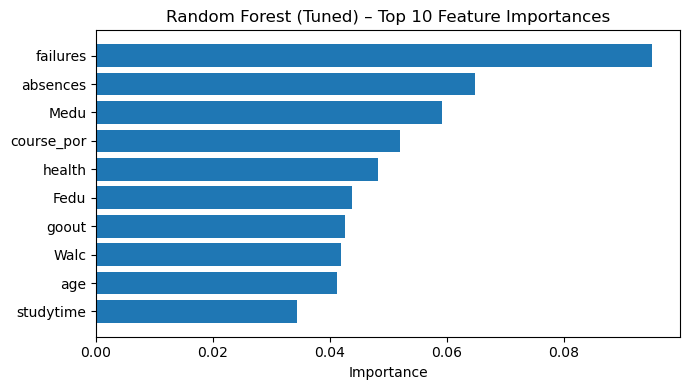

Saved chart to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_feature_importances_top10_tuned.png


In [6]:
# --- Random Forest top-10 feature importances (tuned) ---
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

repo_root = Path.cwd().parent
imp_csv   = repo_root / "data" / "model_outputs" / "rf_feature_importances_tuned.csv"
out_png   = repo_root / "data" / "model_outputs" / "rf_feature_importances_top10_tuned.png"

imp = pd.read_csv(imp_csv).sort_values("importance", ascending=False).head(10)
plt.figure(figsize=(7,4))
plt.barh(imp["feature"][::-1], imp["importance"][::-1])
plt.title("Random Forest (Tuned) – Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(out_png, bbox_inches="tight")
plt.show()
print(f"Saved chart to: {out_png}")


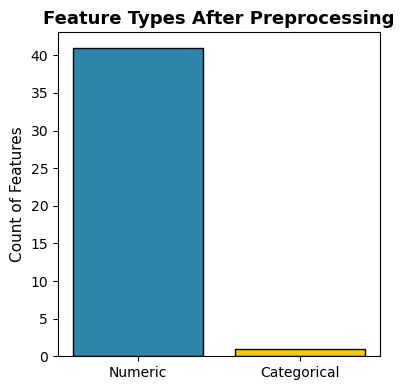

Saved chart to: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/feature_types_after_preprocessing.png


In [9]:
# ============================================
# Appendix Visualization: Feature Types After Preprocessing
# ============================================

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Define repo structure
repo_root = Path.cwd().parent
data_path = repo_root / "data" / "clean" / "student_clean_classification_noG1G2.csv"
out_dir   = repo_root / "data" / "model_outputs"
out_dir.mkdir(parents=True, exist_ok=True)
out_png   = out_dir / "feature_types_after_preprocessing.png"

# Load the cleaned dataset
df = pd.read_csv(data_path)

# Count numeric vs categorical features
categorical = df.select_dtypes(include=['object', 'category']).shape[1]
numeric = df.select_dtypes(exclude=['object', 'category']).shape[1]

# Plot
plt.figure(figsize=(4,4))
plt.bar(["Numeric", "Categorical"], [numeric, categorical],
        color=["#2E86AB", "#F6C90E"], edgecolor="black")
plt.title("Feature Types After Preprocessing", fontsize=13, weight="bold")
plt.ylabel("Count of Features", fontsize=11)
plt.tight_layout()

# Save chart
plt.savefig(out_png, bbox_inches="tight")
plt.show()

print(f"Saved chart to: {out_png}")


Best params: {'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


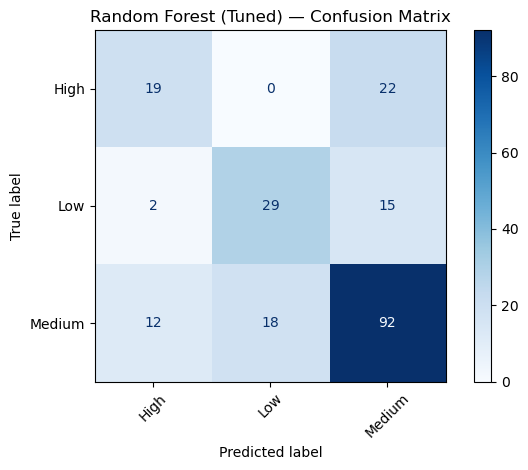

Saved: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_confusion_matrix_tuned.png


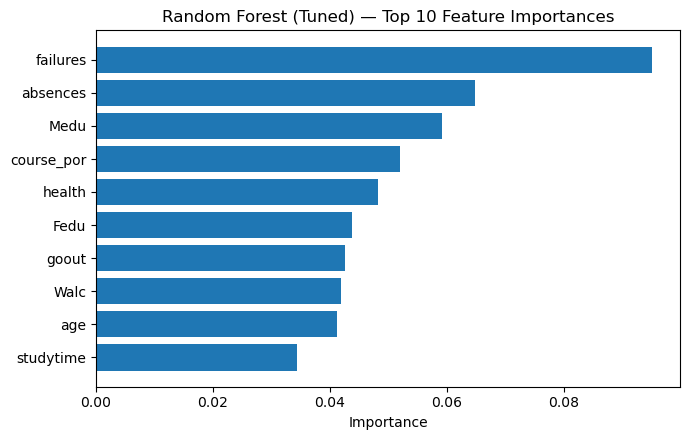

Saved: /Users/gisselletosta/Final-Project-Team-4-AAI500/data/model_outputs/rf_feature_importances_top10_tuned.png


In [14]:
# --- Rebuild tuned Random Forest, then save confusion matrix + top-10 importances ---

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# 0) Paths
repo_root = Path.cwd().parent
data_path = repo_root / "data" / "clean" / "student_clean_classification_noG1G2.csv"
out_dir   = repo_root / "data" / "model_outputs"
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Load data
df = pd.read_csv(data_path)

# 2) Features/target (drop leakage)
TARGET = "performance_level"
LEAK_VARS = {"G1", "G2", "G3"}
X = df[[c for c in df.columns if c not in LEAK_VARS | {TARGET}]].copy()
y = df[TARGET].copy()

# 3) Same split we used everywhere
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 4) Tune RF around the winning region we already found
rf = RandomForestClassifier(class_weight="balanced", random_state=42)
param_grid = {
    "n_estimators": [200],            # best we found
    "max_features": ["log2"],         # best we found
    "min_samples_split": [2],         # best we found
    "min_samples_leaf": [4],          # best we found
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(
    rf, param_grid=param_grid, cv=cv, scoring="f1_macro", n_jobs=-1, refit=True
)
grid.fit(X_train, y_train)
rf_model = grid.best_estimator_
print("Best params:", grid.best_params_)

# 5) Confusion matrix (tuned RF)
cm_png = out_dir / "rf_confusion_matrix_tuned.png"
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model, X_test, y_test, cmap="Blues", xticks_rotation=45
)
plt.title("Random Forest (Tuned) — Confusion Matrix")
plt.tight_layout()
plt.savefig(cm_png, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {cm_png}")

# 6) Top-10 feature importances (tuned RF)
importances = rf_model.feature_importances_
fi = (
    pd.DataFrame({"feature": X.columns, "importance": importances})
    .sort_values("importance", ascending=False)
)
top10 = fi.head(10).iloc[::-1]   # reverse for a nicer horizontal bar
plt.figure(figsize=(7,4.5))
plt.barh(top10["feature"], top10["importance"])
plt.title("Random Forest (Tuned) — Top 10 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
fi_png = out_dir / "rf_feature_importances_top10_tuned.png"
plt.savefig(fi_png, dpi=150, bbox_inches="tight")
plt.show()
print(f"Saved: {fi_png}")


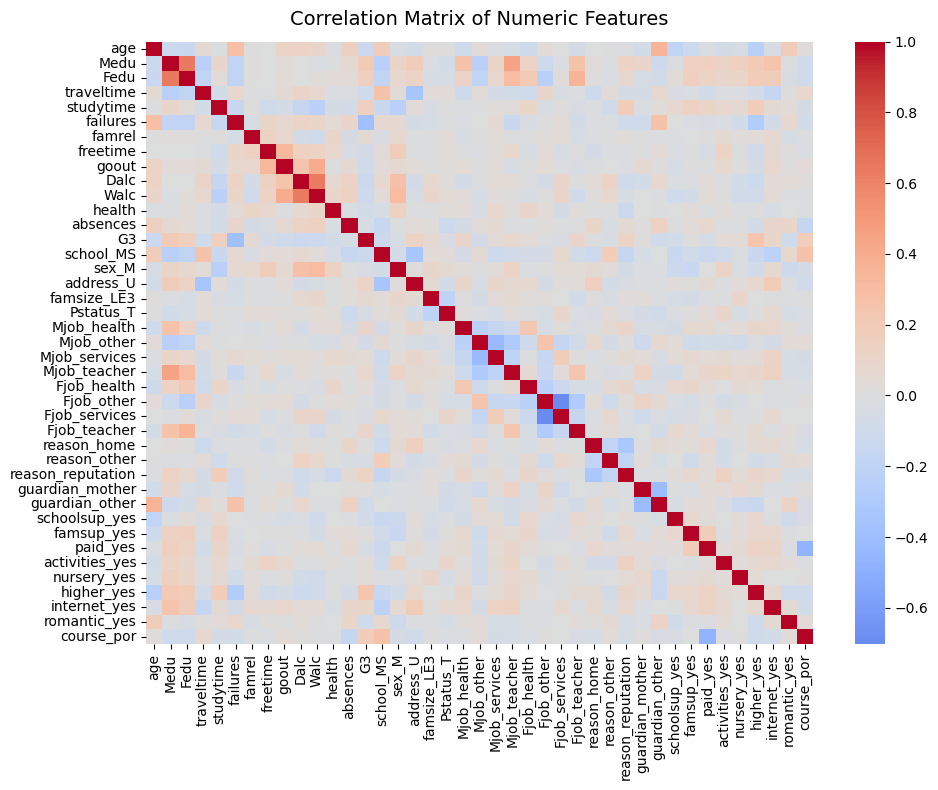

In [1]:
# --- Correlation Matrix of Numeric Features (EDA Visual) ---

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load cleaned dataset (no grade leakage)
df = pd.read_csv("../data/clean/student_clean_classification_noG1G2.csv")

# Compute correlation among numeric features only
corr = df.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix of Numeric Features", fontsize=14, pad=12)
plt.tight_layout()

# Save the plot to data/model_outputs
plt.savefig("../data/model_outputs/correlation_matrix.png", dpi=150)
plt.show()


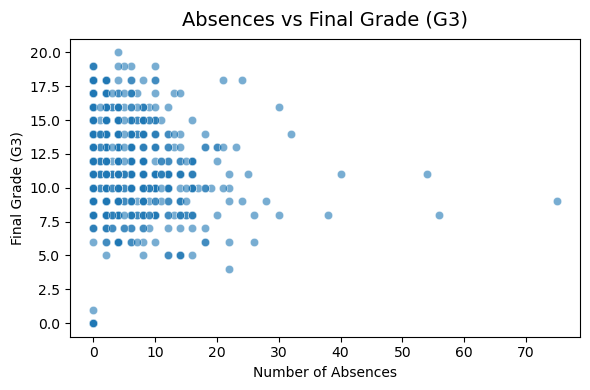

Saved: ../data/model_outputs/absences_vs_grade.png
Shape used for plot: (1044, 2)


In [4]:
# --- Absences vs Final Grade (G3) - FIXED: UCI CSVs use semicolons ---

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Read raw files with correct delimiter
mat = pd.read_csv("../data/raw/student-mat.csv", sep=";")
por = pd.read_csv("../data/raw/student-por.csv", sep=";")

# Combine both courses (optional but gives more points)
df = pd.concat([mat, por], ignore_index=True)

# Keep only rows with numeric absences and G3
df = df[pd.notna(df["absences"]) & pd.notna(df["G3"])]

plt.figure(figsize=(6, 4))
sns.scatterplot(x="absences", y="G3", data=df, alpha=0.6)
plt.title("Absences vs Final Grade (G3)", fontsize=14, pad=10)
plt.xlabel("Number of Absences")
plt.ylabel("Final Grade (G3)")
plt.tight_layout()
plt.savefig("../data/model_outputs/absences_vs_grade.png", dpi=150)
plt.show()

print("Saved: ../data/model_outputs/absences_vs_grade.png")
print("Shape used for plot:", df[["absences","G3"]].shape)


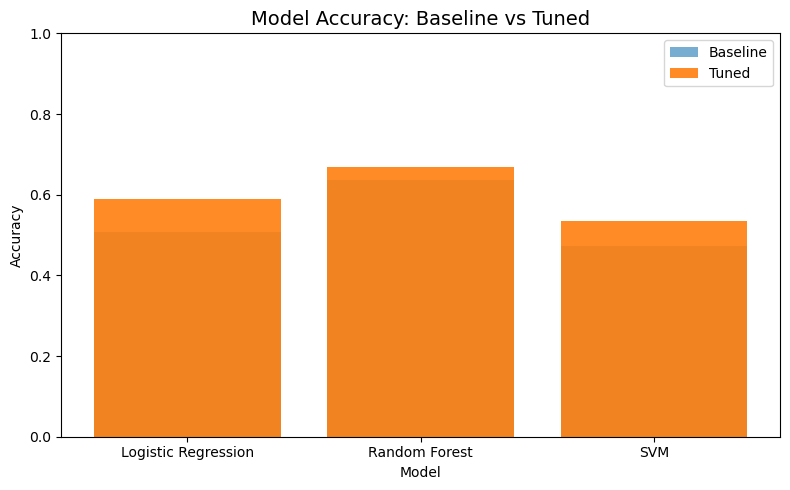

Saved: ../data/model_outputs/model_accuracy_comparison.png


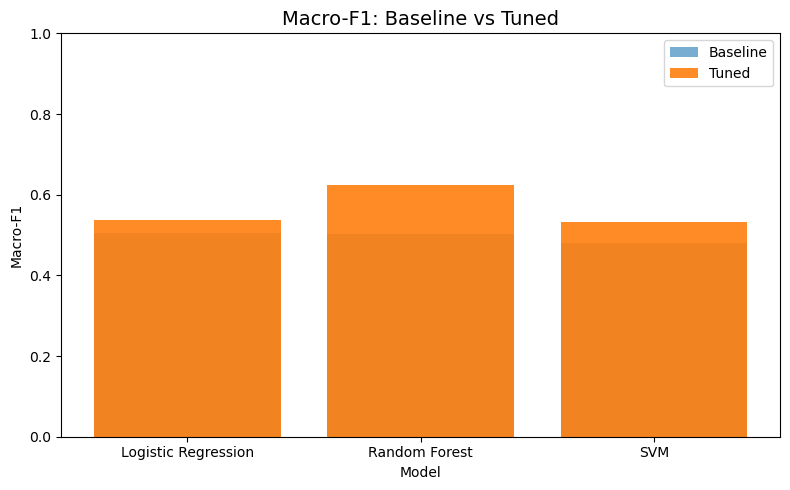

Saved: ../data/model_outputs/model_f1_comparison.png


In [6]:
# ==============================
# Baseline vs Tuned Bar Charts
# ==============================
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Resolve CSV path robustly
candidates = [
    Path("../data/model_outputs/model_metrics_compare_baseline_tuned.csv"),
    Path("data/model_outputs/model_metrics_compare_baseline_tuned.csv"),
]
csv_path = next((p for p in candidates if p.exists()), None)
assert csv_path is not None, "model_metrics_compare_baseline_tuned.csv not found. Check it exists under data/model_outputs/"

df = pd.read_csv(csv_path)

# Normalize model names for grouping
df["Model"] = (
    df["Model"]
    .str.replace(" (no leak)", "", regex=False)
    .str.replace(" (tuned)", "", regex=False)
    .str.replace(" (RBF kernel)", "", regex=False)
    .str.replace(" RBF", "", regex=False)
    .str.replace("SVM", "SVM", regex=False)
)

# We expect Stage to be Baseline or Tuned
stages = ["Baseline", "Tuned"]

# ---- Accuracy chart
plt.figure(figsize=(8, 5))
for stage, alpha in zip(stages, [0.6, 0.9]):
    subset = df[df["Stage"] == stage]
    # Ensure order is consistent
    subset = subset.set_index("Model").reindex(["Logistic Regression", "Random Forest", "SVM"]).reset_index()
    plt.bar(subset["Model"], subset["Accuracy"], alpha=alpha, label=stage)

plt.title("Model Accuracy: Baseline vs Tuned", fontsize=14)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
out1 = Path("../data/model_outputs/model_accuracy_comparison.png")
plt.savefig(out1, dpi=150)
plt.show()
print(f"Saved: {out1}")

# ---- Macro-F1 chart
plt.figure(figsize=(8, 5))
for stage, alpha in zip(stages, [0.6, 0.9]):
    subset = df[df["Stage"] == stage]
    subset = subset.set_index("Model").reindex(["Logistic Regression", "Random Forest", "SVM"]).reset_index()
    plt.bar(subset["Model"], subset["Macro-F1"], alpha=alpha, label=stage)

plt.title("Macro-F1: Baseline vs Tuned", fontsize=14)
plt.ylabel("Macro-F1")
plt.xlabel("Model")
plt.ylim(0, 1.0)
plt.legend()
plt.tight_layout()
out2 = Path("../data/model_outputs/model_f1_comparison.png")
plt.savefig(out2, dpi=150)
plt.show()
print(f"Saved: {out2}")
